In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# provided helper functions
def U(x,y,A):
    N = np.size(A,axis=0)
    xaux = np.outer(x,np.ones_like(x))
    yaux = np.outer(y,np.ones_like(y))
    dx = A*(xaux - np.transpose(xaux))
    dy = A*(yaux - np.transpose(yaux))
    dxy = np.sqrt(dx**2 + dy**2)

    linkedInd = np.argwhere(A == 1)
    sum_linked = np.sum((dxy[linkedInd] - 1)**2)
    sum_linked /= 2

    unlinkedInd = np.argwhere(A == 0)
    sum_unlinked = np.sum((np.minimum(dxy[unlinkedInd] - np.sqrt(3), 0))**2)
    sum_unlinked /= 2

    return sum_linked + sum_unlinked


# forces
def forces(x,y,A):
    N = np.size(A,axis = 0)
    # find pairwise distances 
    xaux = np.outer(x,np.ones(np.shape(x)))
    yaux = np.outer(y,np.ones(np.shape(x)))
    dx = A*(xaux - np.transpose(xaux))
    dy = A*(yaux - np.transpose(yaux))
    dxy = np.sqrt(dx**2 + dy**2)
    # spring forces due to linked vertices
    # optimal distance between linked vertices is 1 
    Aind = np.argwhere(A == 1)
    idiff = np.zeros(np.shape(A))
    Nlinks = np.size(Aind,axis = 0)
    for j in range(Nlinks):
        idiff[Aind[j,0],Aind[j,1]] = 1 - 1/dxy[Aind[j,0],Aind[j,1]]
    
    fx = -np.sum(idiff*dx,axis = 1)
    afx = np.minimum(np.abs(fx),np.ones(np.size(fx)))
    sfx = np.sign(fx)
    fx = afx*sfx
                  
    fy = -np.sum(idiff*dy,axis = 1)
    afy = np.minimum(np.abs(fy),np.ones(np.size(fy)))
    sfy = np.sign(fy)
    fy = afy*sfy
    
    f_linked = np.concatenate((fx,fy),axis = 0)
    
    # repelling spring forces due to unlinked vertices
    # repelling is on if the distance between unlined verticas is greater than sqrt(3)
    h = np.sqrt(3.0)
    A1 = np.ones(np.shape(A)) - A
    dx = A1*(xaux - np.transpose(xaux))
    dy = A1*(yaux - np.transpose(yaux))
    dxy = np.sqrt(dx**2 + dy**2)
    mask = np.zeros(np.shape(A))
    diff = A1*(dxy - h)
    mask = np.minimum(diff,np.zeros(np.shape(diff)))
    fx = np.sum(mask*dx,axis=1)
    fy = np.sum(mask*dy,axis=1)
    f_unlinked = -np.concatenate((fx,fy),axis = 0)
    
    return np.reshape(f_linked + f_unlinked, (182,1))

# plot graph
def plot_graph(x,y,A):
    plt.figure(figsize=(12, 12))
    Aind = np.argwhere(A == 1)
    Nlinks = np.size(Aind,axis = 0)
    for j in range(Nlinks):
        plt.plot([x[Aind[j,0]],x[Aind[j,1]]],[y[Aind[j,0]],y[Aind[j,1]]],linewidth = 4,c = (0,0,0.5))
    plt.scatter(x,y,s=200,c='r')
    axes=plt.gca()
    axes.set_aspect(1)
    plt.axis('off')

In [4]:
# read CSV
AdjMatrix = pd.read_csv('Adjacency_matrix.csv', header=None)
AdjMatrix = AdjMatrix.to_numpy()

In [21]:
# initialize x and y
x = np.random.randn(91,1)*91
y = np.random.randn(91,1)*91
# initalize x and y averages for residuals
xAvgs = x
yAvgs = y 

In [12]:
U(x,y,AdjMatrix)

11857025.399627728

In [22]:
# Nesterov Optimizer
no_epochs = 100000
alpha = 1e-2
m = 0.9
last_change = np.zeros((182,1))

g = -forces(x,y,AdjMatrix)
Fs = np.zeros((no_epochs+1,1))
Fs[0] = np.linalg.norm(g)
print("Initially ||F|| = " + str(np.linalg.norm(g)))
for i in range(1,no_epochs+1):
    projX = x + last_change[0:91]*m
    projY = y + last_change[91:182]*m
    g = -forces(projX, projY,AdjMatrix)
    last_change = (m*last_change) - alpha*g
    x = x + last_change[0:91]
    y = y + last_change[91:182]
    Fs[i] = np.linalg.norm(g)
    xAvgs = (i * xAvgs + x)/(i + 1)
    yAvgs = (i * yAvgs + y)/(i + 1)
    if i % (no_epochs / 200) == 0:
        print("i = " + str(i) + " ||F|| = " + str(np.linalg.norm(g)) + " U(x,y) = " + str(U(x,y,AdjMatrix)))


Initially ||F|| = 13.462048950459485
i = 500 ||F|| = 11.742225418834717 U(x,y) = 5140518.917447265
i = 1000 ||F|| = 9.858787699069392 U(x,y) = 2684734.267750335
i = 1500 ||F|| = 7.277982135370903 U(x,y) = 2225136.2881431715
i = 2000 ||F|| = 4.212919761465238 U(x,y) = 2181901.725069412
i = 2500 ||F|| = 1.3115772271770834 U(x,y) = 2179862.254607424
i = 3000 ||F|| = 0.5244621747788469 U(x,y) = 2180719.1722396277
i = 3500 ||F|| = 0.27596514693099944 U(x,y) = 2181602.547054797
i = 4000 ||F|| = 0.17368638165839548 U(x,y) = 2182172.506988763
i = 4500 ||F|| = 0.11782476166336651 U(x,y) = 2182636.5175024564
i = 5000 ||F|| = 0.08275959718293117 U(x,y) = 2182999.156499956
i = 5500 ||F|| = 0.06010374806119261 U(x,y) = 2183275.34315596
i = 6000 ||F|| = 0.0462892977257323 U(x,y) = 2183466.701504676
i = 6500 ||F|| = 0.03252956688962027 U(x,y) = 2183617.3224493694
i = 7000 ||F|| = 0.025521743939546107 U(x,y) = 2183711.1317091663
i = 7500 ||F|| = 0.02092405956548137 U(x,y) = 2183778.9397207014
i = 8000

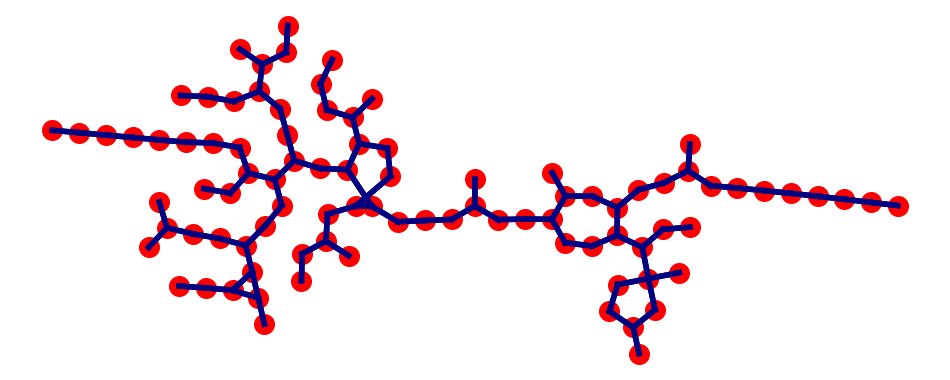

In [18]:
plot_graph(x,y,AdjMatrix)

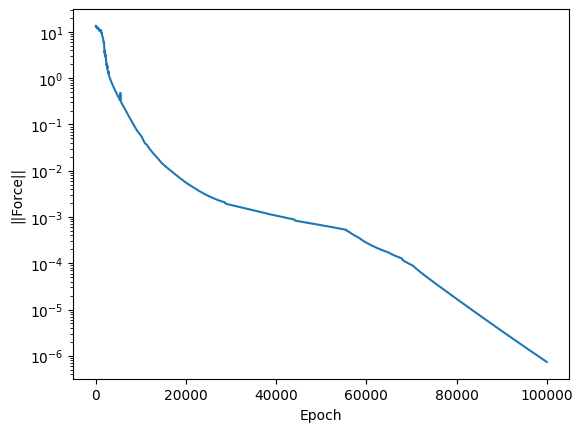

In [19]:
plt.plot(range(0,no_epochs+1), Fs)
plt.xlabel("Epoch")
plt.ylabel("||Force||")
plt.yscale("log")